### DNN - 로지스틱의 한계 극복

## 1. Imports

In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

## 2. 꺾인 확률 그래프를 만들기

증가했다가 내려가는 벡터를 만들어보자

In [3]:
x = torch.linspace(-1, 1, 1001).reshape(-1, 1)
x

tensor([[-1.0000],
        [-0.9980],
        [-0.9960],
        ...,
        [ 0.9960],
        [ 0.9980],
        [ 1.0000]])

In [4]:
y = x*0 + x
y[x < 0] = (9*x+4.5)[x<0]
y[x >= 0] = (-4.5*x + 4.5)[x>=0]

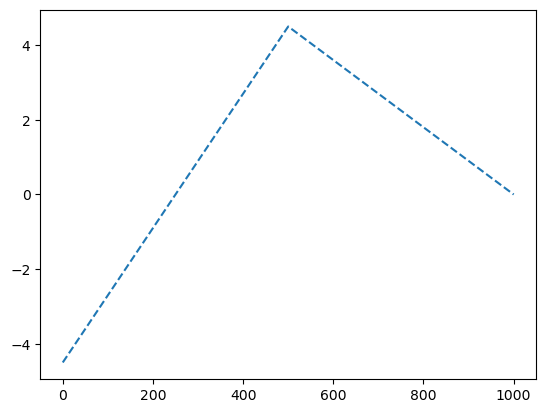

In [5]:
plt.plot(y, '--')

`relu`를 이용하는 방법

In [6]:
relu = torch.nn.ReLU()

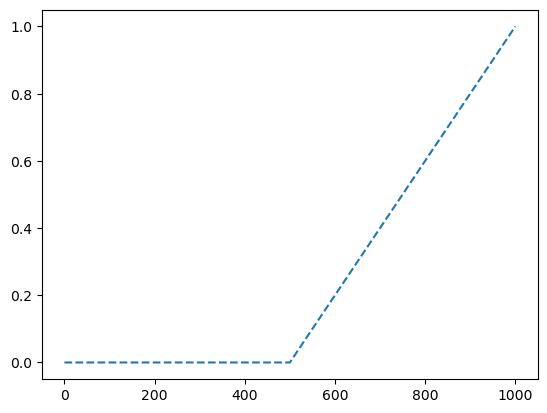

In [7]:
plt.plot(relu(x), '--')  ## 0보다 작은 것은 0이 된다.

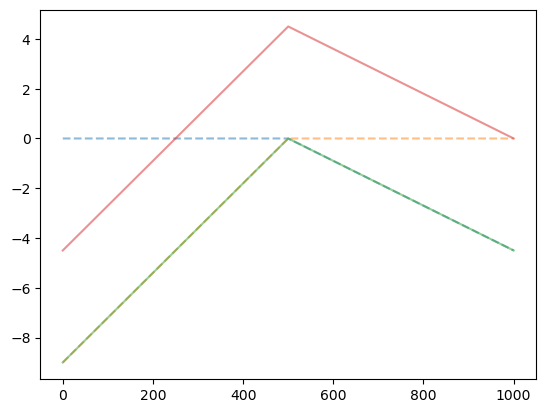

In [8]:
plt.plot(-4.5*relu(x), '--', alpha = 0.5)
plt.plot(-9*relu(-x), '--', alpha = 0.5)
## 두 개를 더하면 꺾인 선이 나온다.
plt.plot(-4.5*relu(x)-9*relu(-x), alpha = 0.5)
## 0 근처로 맞춰주자...
plt.plot(-4.5*relu(x)-9*relu(-x)+4.5, alpha = 0.5)
plt.show()

> 위 빨간 선을 시그모이드에 먹이면 우리가 원하는 모양의 함수가 된다.

In [9]:
sig = torch.nn.Sigmoid()

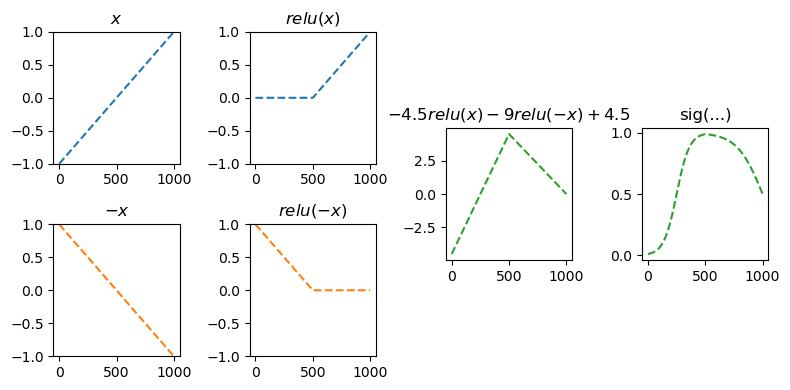

In [10]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title(r'$x$'); ax1.set_ylim(-1,1)
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title(r'$-x$'); ax2.set_ylim(-1,1)
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title(r'$relu(x)$'); ax3.set_ylim(-1,1)
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title(r'$relu(-x)$'); ax4.set_ylim(-1,1)
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title(r'$-4.5 relu(x)-9 relu(-x)+4.5$')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('sig(...)');
#---#
ax1.plot(x,'--',color='C0')
ax2.plot(-x,'--',color='C1')
ax3.plot(relu(x),'--',color='C0')
ax4.plot(relu(-x),'--',color='C1')
ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
ax6.plot(sig(-4.5*relu(x)-9*relu(-x)+4.5),'--',color='C2')
fig.tight_layout()

> $x$를 바로 시그모이드에 먹이는 것이 아닌 일종의 변환을 한 뒤에 시그모이드에 먹임으로써 원하는 확률 그래프 형태를 만들 수 있다.

### 단계별로 정리

1. 벡터 `x`와 `relu` 함수를 준비한다.
2. `u = [x, -x]`를 계산한다.
3. `v = [relu(x), relu(-x)]`를 계산한다.
4. `y = a*relu(x) + b*relu(-x) + c`를 계산한다.

In [23]:
## step 1
x = torch.linspace(-1, 1, 1001).reshape(-1, 1)  ## column vector로 변환
relu = torch.nn.ReLU()

## step 2
u = torch.concat([x, -x], axis = 1)

## step 3
v = relu(u)

## step 4
-4.5 * v[:, [0]] - 9.0 * v[:, [1]] + 4.5 ## axis = 1

tensor([[-4.5000],
        [-4.4820],
        [-4.4640],
        ...,
        [ 0.0180],
        [ 0.0090],
        [ 0.0000]])

위 폼을 참고하여 매트릭스의 곱 형태로 다시 표현하면?

In [13]:
What = torch.tensor([[-4.5], [-9.0]])
v @ What + 4.5

tensor([[-4.5000],
        [-4.4820],
        [-4.4640],
        ...,
        [ 0.0180],
        [ 0.0090],
        [ 0.0000]])

이 매트릭스의 곱 대신 `torch.nn.Linear()`를 이용하면??

In [14]:
## v --> y
l2 = torch.nn.Linear(
    in_features = 2,
    out_features = 1
)

In [18]:
## 피팅이 안되서 아직 다름
print(l2.weight.data)
print(l2.bias.data)

tensor([[0.0111, 0.4342]])
tensor([-0.3338])


In [27]:
## 초기값 세팅
l2.bias.data = torch.tensor([4.5])
l2.weight.data = torch.tensor([[-4.5, -9.0]])  ## column vector를 넣어야 작동

In [28]:
l2(v)  ## y와 똑같아짐. ㅇㅇ

tensor([[-4.5000],
        [-4.4820],
        [-4.4640],
        ...,
        [ 0.0180],
        [ 0.0090],
        [ 0.0000]], grad_fn=<AddmmBackward0>)

`-` 사실 2단계도 아래처럼 쓸 수 있음

In [29]:
l1 = torch.nn.Linear(
    in_features = 1,
    out_features = 2
)

In [32]:
l1.weight.data = torch.tensor([[1.0], [-1.0]])

In [34]:
l1.bias.data = torch.tensor([0.0, 0.0])

In [35]:
l1(x)  ## u를 만들 수 있음.

tensor([[-1.0000,  1.0000],
        [-0.9980,  0.9980],
        [-0.9960,  0.9960],
        ...,
        [ 0.9960, -0.9960],
        [ 0.9980, -0.9980],
        [ 1.0000, -1.0000]], grad_fn=<AddmmBackward0>)

그럼 위를 종합해서...

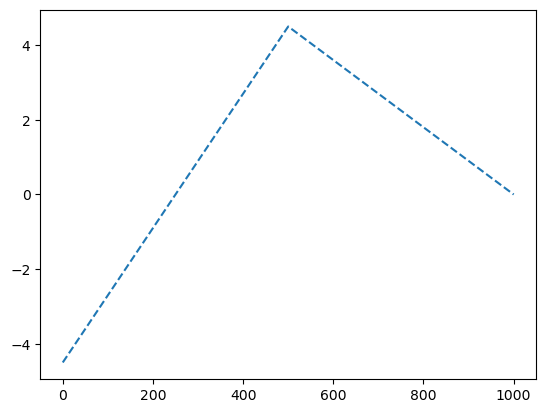

In [41]:
plt.plot(l2(relu(l1(x))).data, '--')

### 과정의 종합

In [43]:
l1 = torch.nn.Linear(in_features = 1, out_features = 2)
l1.weight.data = torch.tensor([[1.0], [-1.0]])
l1.bias.data = torch.tensor([0.0, 0.0])
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(in_features = 2, out_features = 1)
l2.weight.data = torch.tensor([[-4.5, -9.0]])
l2.bias.data = torch.tensor([0.0])

l2(a1(l1(x)))

tensor([[-9.0000],
        [-8.9820],
        [-8.9640],
        ...,
        [-4.4820],
        [-4.4910],
        [-4.5000]], grad_fn=<AddmmBackward0>)

`-` 각각의 layer를 `torch.nn.Sequential()`로 묶으면?

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1)
)
l1,a1,l2 = net  ## unpacking
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

## 4. 로지스틱의 한계 극복

In [44]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
df

,x,prob,y
0,-1.000000,0.000045,0.0
1,-0.998999,0.000046,0.0
2,-0.997999,0.000047,0.0
3,-0.996998,0.000047,0.0
4,-0.995998,0.000048,0.0
...,...,...,...
1995,0.995998,0.505002,0.0
1996,0.996998,0.503752,0.0
1997,0.997999,0.502501,0.0
1998,0.998999,0.501251,1.0


In [52]:
x = torch.tensor(df.x).float().reshape(-1, 1)  ## float을 붙인 건 방어적으로 코딩한 거인듯...? 아마도?
y = torch.tensor(df.y).float().reshape(-1, 1)
prob = torch.tensor(df.prob).float().reshape(-1, 1)

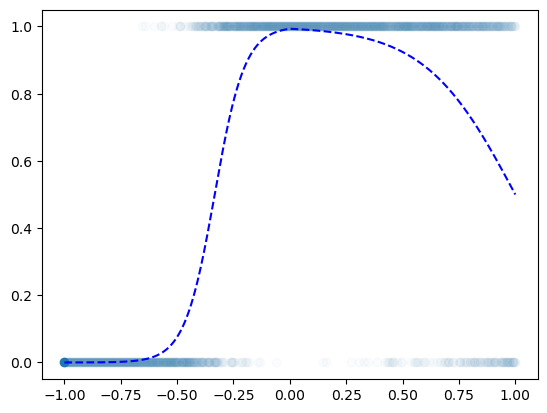

In [55]:
plt.plot(x, y, 'o', alpha = 0.02)
plt.plot(x[0], y[0], 'o', color = "C0")
plt.plot(x, prob, '--b')

그냥 시그모이드를 취하면 언더피팅이 발생하는데, 그것을 처음 데이터 자체를 변환시켜 해결하였음.

## 5. Analysis Step 1~4

`-` Step 1 : 네트워크를 어떻게 만들까? = 아키텍쳐를 어떻게 만들까? = 모델링

$$\underset{(n, 1)}{\bold{X}} \overset{l_1}{\to} \underset{(n, 2)}{u^{(1)}} \overset{a_1}{\to} \underset{(n, 2)}{v^{(1)}} \overset{l_2}{\to} \underset{(n, 1)}{u^{(2)}} \overset{a_2}{\to} \underset{(n, 1)}{v^{(2)}} = \underset{(n, 1)}{\bold{\hat y}}$$

원본 피쳐를 선형변환하여 차원을 확장시키고(l1), 렐루로 변환(a1), 그리고 다시 원래 차원으로 선형변환한 뒤(l2), 시그모이드를 먹인다(a2).

In [62]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

#---#
for epoc in range(3000) :
    ## step 1
    yhat = net(x)
    ## step 2
    loss = loss_fn(yhat, y) ## BCE Loss의 경우 yhat과 y의 순서가 바뀌면 안됨
    ## step 3
    loss.backward()
    ## step 4
    optimizr.step()
    optimizr.zero_grad()

In [63]:
net(x)

tensor([[0.0049],
        [0.0050],
        [0.0050],
        ...,
        [0.8421],
        [0.8421],
        [0.8420]], grad_fn=<SigmoidBackward0>)

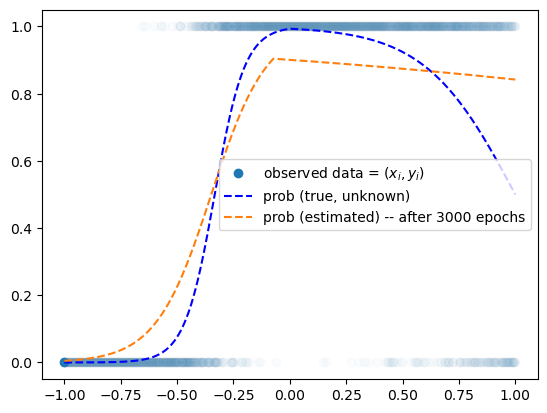

In [64]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 3000 epochs")
plt.legend()

In [65]:
for epoc in range(3000) :
    ## step 1
    yhat = net(x)
    ## step 2
    loss = loss_fn(yhat, y) ## BCE Loss의 경우 yhat과 y의 순서가 바뀌면 안됨
    ## step 3
    loss.backward()
    ## step 4
    optimizr.step()
    optimizr.zero_grad()

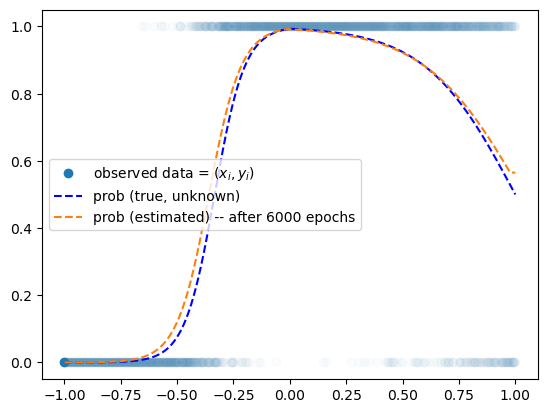

In [66]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 6000 epochs")
plt.legend()

`-` Summary

층이 여러개라는 점에서 깊은 신경망, DNN.

단순한 신경망으로는 XOR 문제를 풀 수 없다는 배경에서 나옴.

> 일반적인 경향(선형)이 나오지 않는 문제를 풀이할 수 있다.

근데 모델링은 어떻게 함?

> Sequance를 엄청나게 많은 종류로 만들고, 노드들 중 가장 좋은 거 하나 고르면 됨.